Analysing fitted data from Jaume University

Defining functions

In [251]:
import json 
import math
import numpy as np
import matplotlib.pyplot as plt

def getmeasurementTimestamp(item):
    return int(item['measurementTimestamp'])
def getProcessingTimestamp(item):
    return int(item['processingTimestamp'])

def get_x_error(item): #the error in the data is the stdev of the sample, we compute the error of the estimation (the sample mean)
    return item['value']['averagecoordinate']['error']['coordinates'][0]/math.sqrt(item['value']['trackeeHistory']['nMeasurements'])

def get_y_error(item):
    return item['value']['averagecoordinate']['error']['coordinates'][1]/math.sqrt(item['value']['trackeeHistory']['nMeasurements'])

def get_fitted(item):
     return item['value']['trackeeHistory']['fitStatus']
    
def get_x_sample_error(item): 
    return item['value']['averagecoordinate']['error']['coordinates'][0]
def get_y_sample_error(item):
    return item['value']['averagecoordinate']['error']['coordinates'][1]

def get_probChi2(item):
    return item['value']['trackeeHistory']['probChi2'] 
def get_Chi2PerDof(item):
    return item['value']['trackeeHistory']['chi2PerDof'] 

def plotHistogramOfDictionary(dictionary, xlabel, ylabel, nbins):
    dictionaryList = []
    for address in dictionary.keys():
        dictionaryList.append(dictionary[address])
    dictArray = np.array(dictionaryList)
    plt.hist(dictArray, bins = nbins)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)
    axes = plt.gca()
    plt.show()
    
def getX(line):
    coordinates = line["value"]["averagecoordinate"]["avg"]["coordinates"]
    return coordinates[0]

def getY(line):
    coordinates = line["value"]["averagecoordinate"]["avg"]["coordinates"]
    return coordinates[1]

Reading fitted data

In [258]:
for i in [0]:
    data = []
    with open("F:/ArenaData/Fingerprinting/fingerprints_GPS.json") as f:
    #with open("arena/2015-07-05_raw.json") as f:
        data = f.readlines()

    json_lines = []
    mac_adresses = []
    
    for line in data:
        jsline = json.loads(line)
        jsline["measurementTimestamp"]/=1000
        json_lines.append(jsline)#now json_lines contains all lines of data
        mac_adresses.append(jsline["value"]["sourceMac"]) # mac_addresses is a list of address per line
        
#sorting by time
json_lines.sort(key = getmeasurementTimestamp) # now json_lines is sorted by time

Computation of error etc

In [216]:

minTime = getmeasurementTimestamp(json_lines[0])
maxTime = getmeasurementTimestamp(json_lines[len(json_lines) - 1])
print("minTime="+ str(minTime))
print("maxTime="+ str(maxTime))

timeMinutes = (maxTime - minTime)/60
print("time in seconds = ", str(maxTime - minTime))
print("time in hours = ", str(timeMinutes/60/60))


minTime=1369908924
maxTime=1774062978
time in seconds =  404154054
time in hours =  1871.0835833333333


Computing FirstTimeSeen and LastTimeSeen for every address

In [217]:
concertFinishedTimestamp=maxTime
FirstTimeSeen=dict()
LastTimeSeen=dict()

for jsline in json_lines:
    address = jsline["value"]["sourceMac"]
    time =  getmeasurementTimestamp(jsline)
    if address in FirstTimeSeen:        
        if time < FirstTimeSeen[address]:
            FirstTimeSeen[address] = time
    else:
        FirstTimeSeen[address] = time
        
    if address in LastTimeSeen:         
        if time > LastTimeSeen[address]:
            LastTimeSeen[address] = time
    else:
        LastTimeSeen[address] = time

Computing dwell time, number of persistent addresses, and number of addresses visible in every second

In [218]:
DwellTime = dict()
DwellTimeDuringConcert = dict()
numberOfAdressesAtConcert=0
for address in LastTimeSeen.keys():    
    DwellTime[address] = int((LastTimeSeen[address] - FirstTimeSeen[address]) /60) # in minutes
    if LastTimeSeen[address] <= concertFinishedTimestamp:
        numberOfAdressesAtConcert += 1
        DwellTimeDuringConcert[address] = DwellTime[address]  
print('number of addresses detected during concert hours:')
print(numberOfAdressesAtConcert)
longTermAddresses=[]
numberOfAddresses = []
AddressesInSec = []
for jsline in json_lines:
    sec = int(math.floor((getmeasurementTimestamp(jsline)- minTime)))
    #print(str(sec))
    address = jsline["value"]["sourceMac"]
    if DwellTime[address] > 0:#  i.e. >1 minutes 
        longTermAddresses.append(address)
        if len(AddressesInSec) <= sec:
            while len(AddressesInSec) <= sec:
                AddressesInSec.append([])                
            AddressesInSec[sec].append(address)                       
        else:
            if address not in AddressesInSec[sec]:                                
                AddressesInSec[sec].append(address)
for setje in AddressesInSec:
    numberOfAddresses.append(len(setje)) 
longTermCount = len(set(longTermAddresses))                
print("Long term persistent addresses (>=1 min)= " + str(longTermCount))
average = 0            
maxN = 0
for addresses in AddressesInSec:            
    average += len(addresses) 
    maxN = max(len(addresses), maxN)
average /= len(AddressesInSec)   
print("averageNumberOfAddressesPerSecondAtConcert " + str(average))
print(maxN)

number of addresses detected during concert hours:
17
Long term persistent addresses (>=1 min)= 16
averageNumberOfAddressesPerSecondAtConcert 0.007767295012855269
8


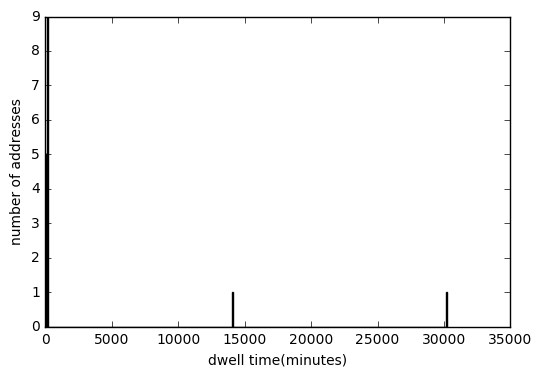

In [192]:
plotHistogramOfDictionary(DwellTimeDuringConcert, "dwell time(minutes)", "number of addresses", 300)

Drawing how many addresses per second are visible (later there is another way to compute this)

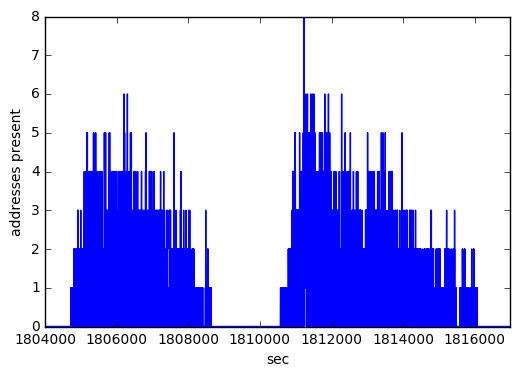

In [219]:
import matplotlib.pyplot as plt
plt.plot(numberOfAddresses)
plt.ylabel('addresses present')
plt.xlabel('sec')
axes = plt.gca()
axes.set_xlim([1804000,1817000])
axes.set_ylim([0,max(numberOfAddresses)])
plt.show()

Just a dictionary that indicates for every address whether it is randomized or not

In [220]:
Randomized = dict()
PersistentRandomized = dict()
count0 = 0
count1 = 0
for line in json_lines:
    address = line["value"]["sourceMac"]
    if line["value"]["trackeeHistory"]["localMac"] == 1 :
        count1 +=1
        Randomized[address] = 1
        if DwellTime[address] > 10: 
            if LastTimeSeen[address] < concertFinishedTimestamp:
                PersistentRandomized[address] = 1 
    else:
        count0 +=1
        Randomized[address] = 0
        if DwellTime[address] > 10: 
            if LastTimeSeen[address] < concertFinishedTimestamp:
                PersistentRandomized[address] = 0 

zeros=0
ones=0
zerosPersistent = 0
onesPersistent = 0
for key in Randomized.keys():
    if Randomized[key]==0:
        zeros +=1
    else:
        ones +=1
for key in PersistentRandomized.keys():
    if PersistentRandomized[key]==0:
        zerosPersistent +=1
    else:
        onesPersistent +=1        
print("total number of lines with localMac == 1: " + str(count1))
print("total number of lines with localMac == 0: " + str(count0))
print("total number of addresses with localMac == 1: " + str(ones))
print("total number of addresses with localMac == 0: " + str(zeros))
print("total number of persistent addresses with localMac == 1: " + str(onesPersistent))
print("total number of persistent addresses with localMac == 0: " + str(zerosPersistent))

total number of lines with localMac == 1: 0
total number of lines with localMac == 0: 19937
total number of addresses with localMac == 1: 0
total number of addresses with localMac == 0: 17
total number of persistent addresses with localMac == 1: 0
total number of persistent addresses with localMac == 0: 15


In [221]:
DwellTimeConcertRandomized = dict()
DwellTimeConcertNonRandomized = dict()
for key in DwellTimeDuringConcert.keys():
    if Randomized[key] == 0:
        DwellTimeConcertNonRandomized[key] = DwellTimeDuringConcert[key]
    else:
        DwellTimeConcertRandomized[key] = DwellTimeDuringConcert[key]

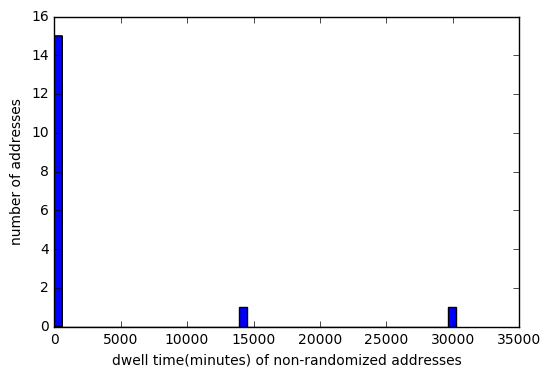

In [222]:
plotHistogramOfDictionary(DwellTimeConcertNonRandomized, "dwell time(minutes) of non-randomized addresses", "number of addresses", 50)

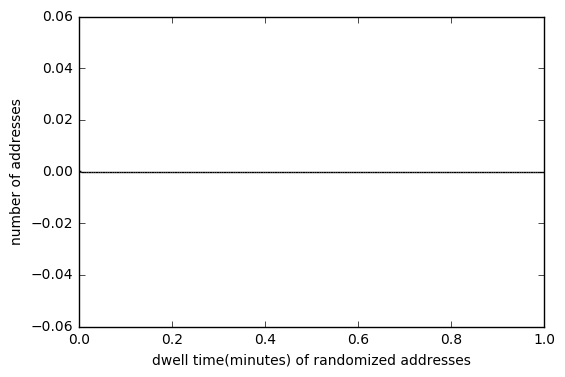

In [223]:
plotHistogramOfDictionary(DwellTimeConcertRandomized, "dwell time(minutes) of randomized addresses", "number of addresses",200)

Double-check:another approach to computing visible addresses per second

Computes visible addresses per time_interval with a specified localMac tag, time_interval in seconds

In [224]:
# checking the trajectory of a certain address, error used is sample error (not error of the estimation of the mean) 
lines = []#will contain only the lines for that address
for line in json_lines:
    address = line["value"]["sourceMac"]
    #if (address == '27e573c8-1640-4ea8-86d8-0733c800e9cd'):#this is the address we are checking for, non-randomized
    if (math.floor(address) == 11):
    #if (address == '8b8a2356-d11e-4bd5-bb35-d8370bf48b1e'):#randomized address    
        lines.append(line)       
x_coord = []
y_coord = []
times = []
x_errors = []
y_errors = []
for line in lines:  
    d=9
    if True :    
        coordinates = line["value"]["averagecoordinate"]["avg"]["coordinates"]
        time = math.floor(line["measurementTimestamp"])-minTime      
        if time not in times:       
            x_coord.append( coordinates[0])
            y_coord.append(coordinates[1])
            x_errors.append(0.1)# for a 95% confidence
            y_errors.append(0.1)# for a 95% confidence
            times.append(time)
    
print(len(x_errors)) 
print(len(x_coord))

497
497


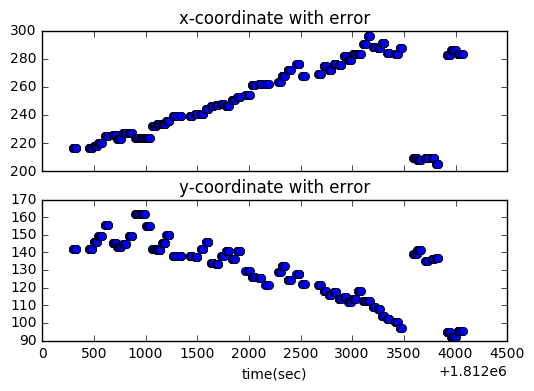

In [225]:
#drawing hte x and y coordinates
import numpy as np
import matplotlib.pyplot as plt

fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True)
#ax0.errorbar(times, x_coord, yerr=x_errors)
ax0.errorbar(times, x_coord, yerr=x_errors, fmt='o')
ax0.set_title('x-coordinate with error')
plt.xlabel('time(sec)')

#ax1.errorbar(times, y_coord, yerr=y_errors)
ax1.errorbar(times, y_coord, yerr=y_errors, fmt='o')
ax1.set_title('y-coordinate with error')

plt.show()

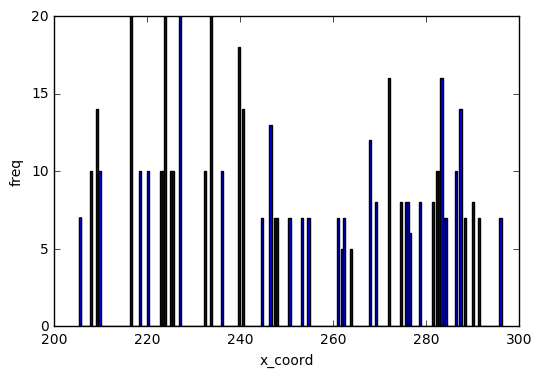

In [226]:
coor = dict()
count =0
for x in x_coord:
    key = times[count]
    coor[key] = x
    count +=1
plotHistogramOfDictionary(coor,  'x_coord', 'freq', 200)

In [201]:
13000/60

216.66666666666666

In [202]:
216/60

3.6

In [259]:
def get_coords(phone):    
    # checking the trajectory of a certain address, error used is sample error (not error of the estimation of the mean) 
    lines = []#will contain only the lines for that address
    for line in json_lines:
        address = line["value"]["sourceMac"]
        #if (address == '27e573c8-1640-4ea8-86d8-0733c800e9cd'):#this is the address we are checking for, non-randomized
        if (math.floor(address) == phone):
        #if (address == '8b8a2356-d11e-4bd5-bb35-d8370bf48b1e'):#randomized address    
            lines.append(line)       
    x_coord = []
    y_coord = []
    times = []
    x_errors = []
    y_errors = []
    for line in lines:  
        d=9
        if True :    
            coordinates = line["value"]["averagecoordinate"]["avg"]["coordinates"]
            time = math.floor(line["measurementTimestamp"])-minTime      
            if time not in times and time >=1804000 and time <= 1817000:       
            #if time not in times and time >=1811000 and time <= 1812000: 
                x_coord.append( coordinates[0])
                y_coord.append(coordinates[1])
                x_errors.append(0.1)# for a 95% confidence
                y_errors.append(0.1)# for a 95% confidence
                times.append(time)
    
    #print(len(x_errors)) 
    #print(len(x_coord))
    return (x_coord, y_coord)

1
3
6
7
8
11
13
14
16
17
19
22
23
24


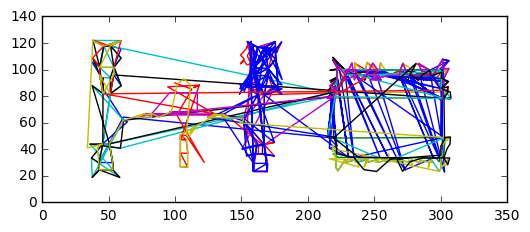

In [263]:
for address in range(0,26):
    (x, y) = get_coords(address)
    #print(y)
    if len(x) > 0:
        print(address)
        plt.plot(x,y)
        #plt.xlim(200, 320)        
        #plt.ylim(20,120)
        plt.gca().set_aspect('equal', adjustable='box')
plt.show()    

0


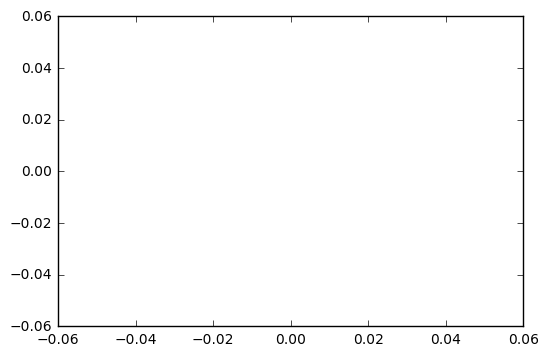

1


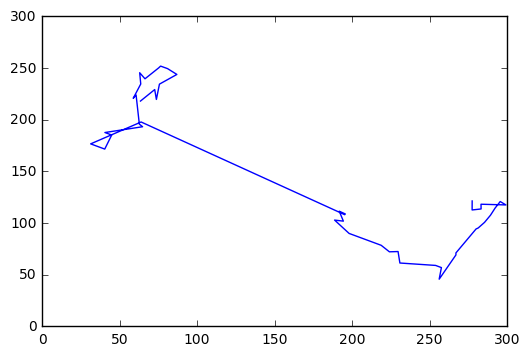

2


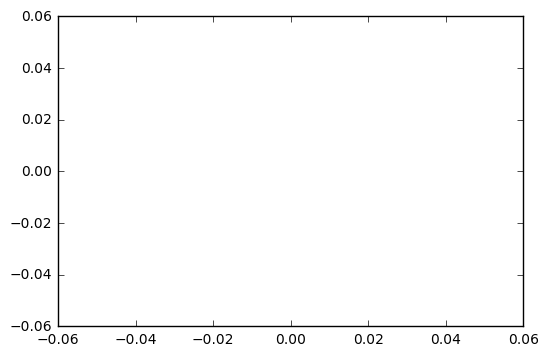

3


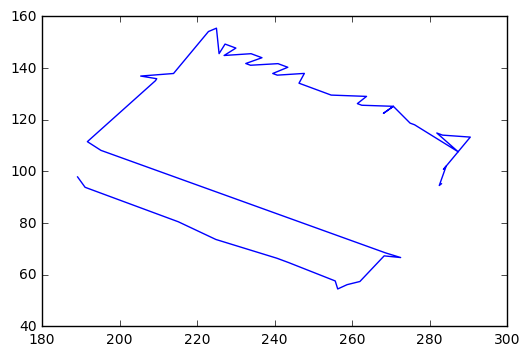

4


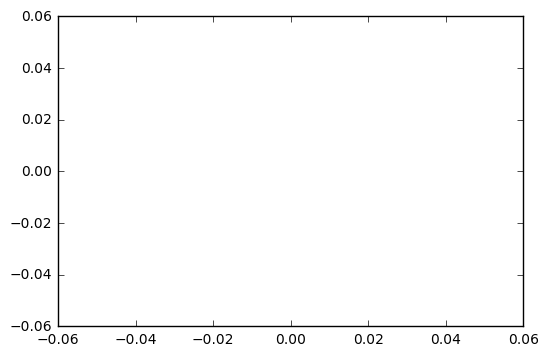

5


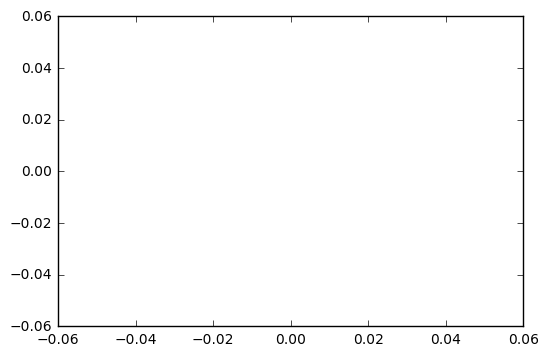

6


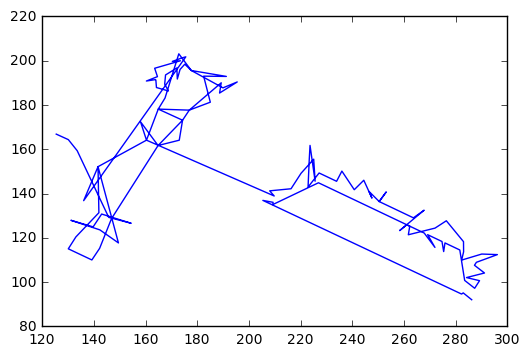

7


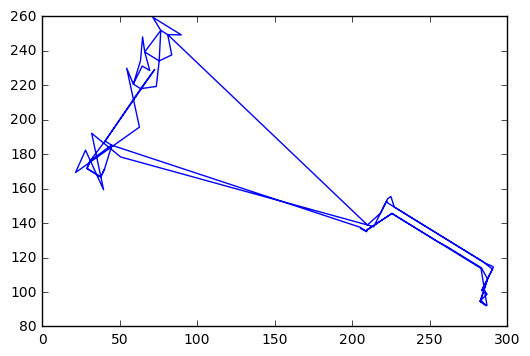

8


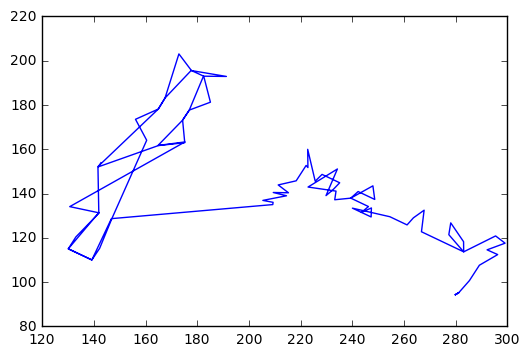

9


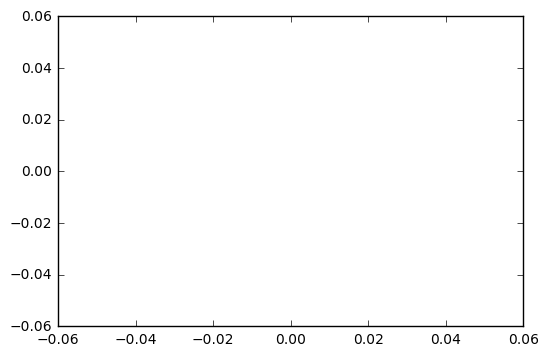

10


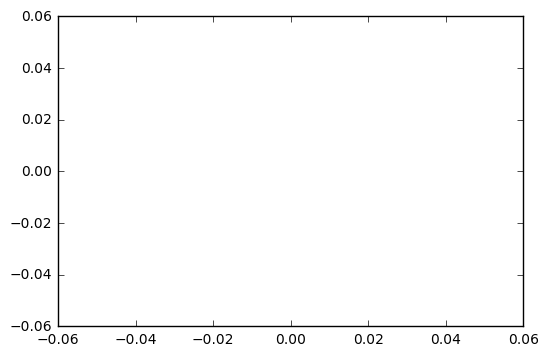

11


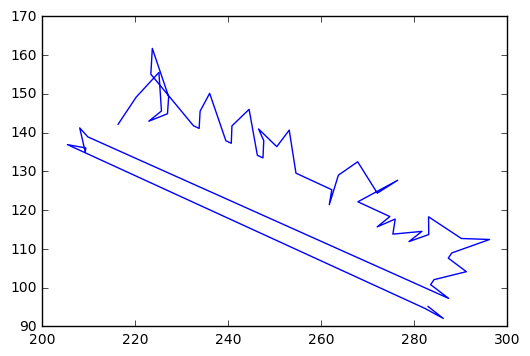

12


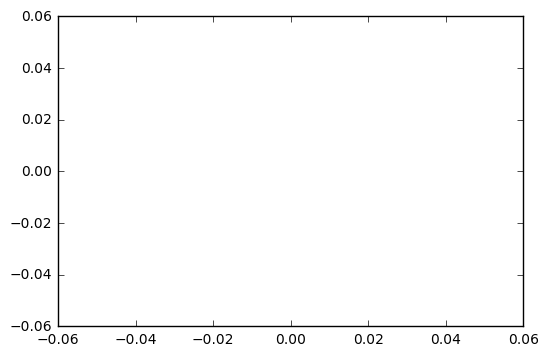

13


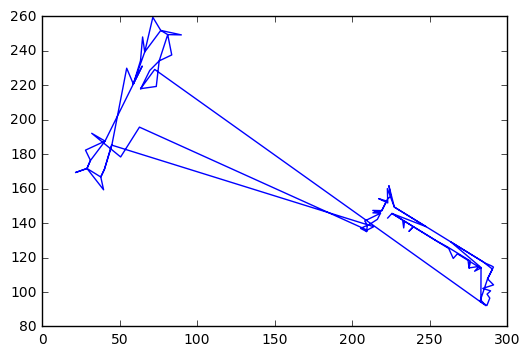

14


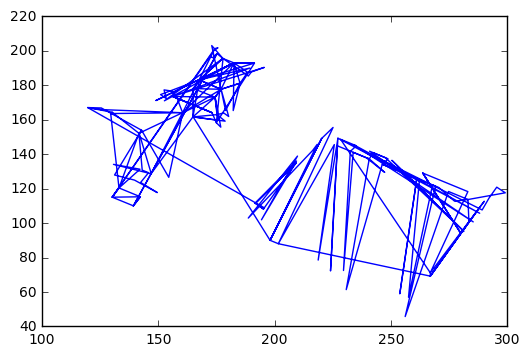

15


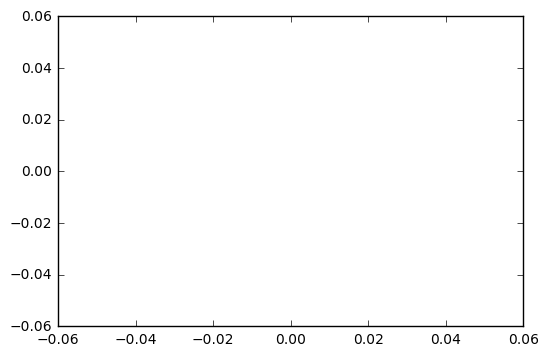

16


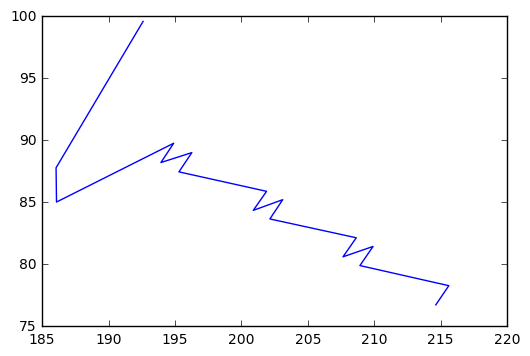

17


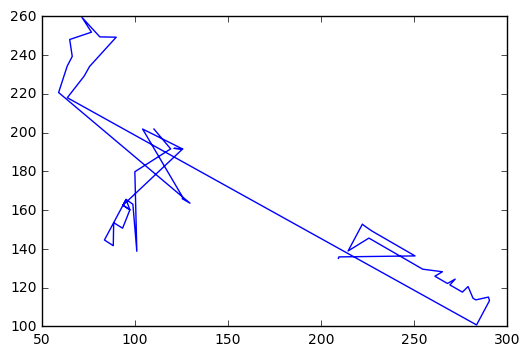

18


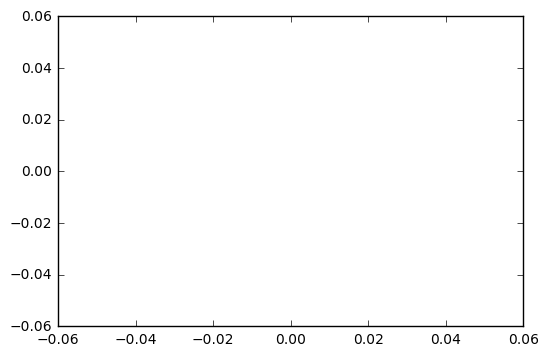

19


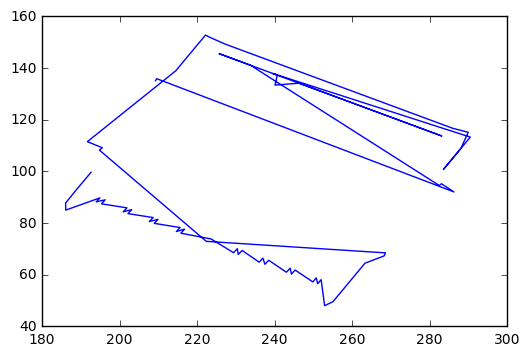

20


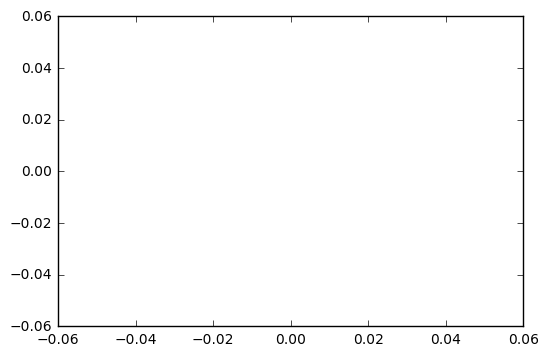

21


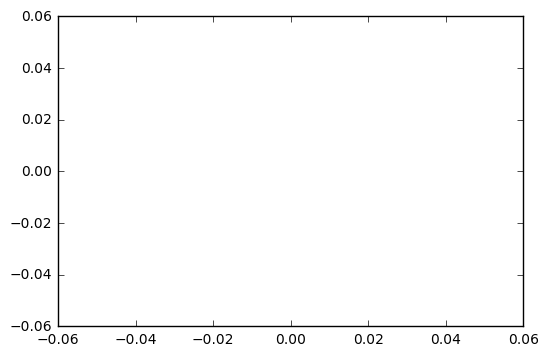

22


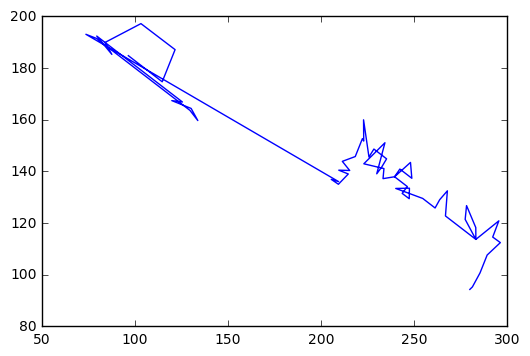

23


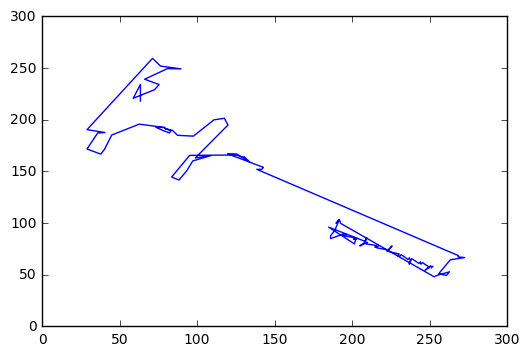

24


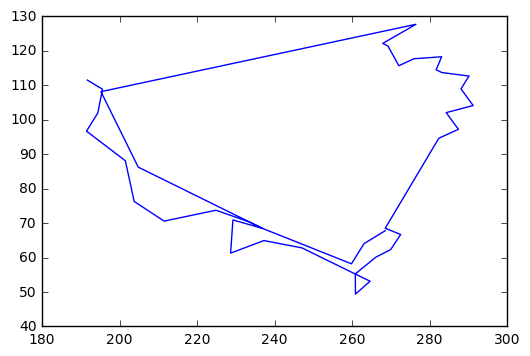

25


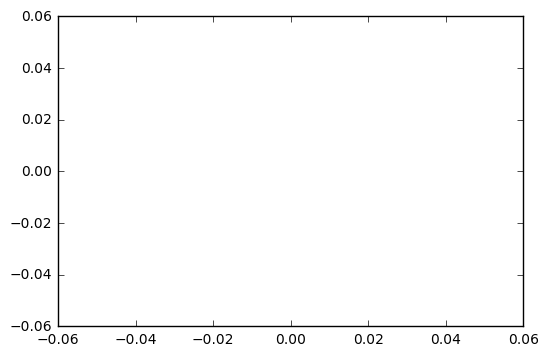

In [205]:
for address in range(0,26):
    (x, y) = get_coords(address)
    plt.plot(x,y)
    print(address)
    plt.show()   

In [153]:
42000/365

115.06849315068493

In [154]:
21*13*1000/6

45500.0

In [156]:
1828821/30

60960.7